# <span style="color:#0F19C9">Contenido</span>

- [Importar Librerías y Datos](#importar-librerías-y-datos)
- [Análisis de Componentes Principales](#análisis-de-componentes-principales)
- [Entrenar Modelos](#entrenar-modelos)
    - [Regresión Logística](#regresión-logística)
    - [Perceptrón](#perceptrón)
    - [Máquina de Soporte Vectorial](#máquina-de-soporte-vectorial)
    - [Clasificador SGD](#clasificador-sgd)
    - [Vecinos Cercanos](#vecinos-cercanos)
    - [Bosque Aleatorio](#bosque-aleatorio)
    - [Red Neuronal](#red-neuronal)
    - [CatBoost](#catboost)
    - [LightGBM](#lightgbm)
- [Evaluar los Modelos](#evaluar-los-modelos)
- [Afinar Red Neuronal](#afinar-red-neuronal)
- [Volver a los Componentes Principales](#volver-a-los-componentes-principales)
- [Aplicar Modelo a Conjunto de Prueba](#aplicar-modelo-a-conjunto-de-prueba)

# <span style="color:#0F19C9">Importar librerías y datos</span>

In [1]:
# Librerías de manejo de dataframes
import pandas as pd
import numpy as np
from datetime import datetime

# Librerías de visualización
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# Librería de Análisis de Componentes Principales
from sklearn.decomposition import PCA

# Librerías de preprocesamiento
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Librerías de modelos de clasificación
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Perceptron
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# Librerías de métricas
from sklearn.metrics import roc_curve, auc

# Librería de modificación de hiperparámetros
from sklearn.model_selection import GridSearchCV

In [2]:
# Comenzar cuenta de tiempo de ejecución
proyect_time = datetime.now()

# Importar paletas de colores personalizada
juan_colors = ['#101B4B', '#545E85', '#A3A8B2',
               '#E7E7E7', '#0F19C9', '#F6D673']
colors = [juan_colors[5], juan_colors[0]]
juan_cmap = LinearSegmentedColormap.from_list("custom_cmap", colors)

# Configurar la fuente de los gráficos
plt.rc('font', family='Georgia', size=12)

In [3]:
# Importar el dataframe preprocesado para el modelo
df = pd.read_csv('../Data/Processed.csv')
df.sample(2)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,StartYear,StartMonth,Churn
4533,Two year,True,Bank transfer (automatic),105.15,7555.0,Female,False,True,False,Fiber optic,False,True,True,False,True,True,True,2014,3,0
61,Month-to-month,True,Bank transfer (automatic),89.90,5450.7,Male,False,False,False,Fiber optic,False,True,False,False,True,False,True,2015,2,0


Podemos importar directamente el dataframe preprocesado que creamos en el cuaderno `EDA.ipynb`.

# <span style="color:#0F19C9">Análisis de Componentes Principales</span>

TODO: ¿Hay que estandarizar las columnas categóricas?
TODO: ¿Cómo controlo todo mi análisis inicial en el PCA?

In [4]:
# Convertimos las diferentes categorías a números
cat_cols = ['Type', 'PaperlessBilling', 'PaymentMethod', 'Gender',
            'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
            'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
            'TechSupport', 'StreamingTV', 'StreamingMovies',
            'MultipleLines']
for col in cat_cols:
    cat_encoder = LabelEncoder()
    df[col] = cat_encoder.fit_transform(df[col].astype(str))

# Mostrar dos registros aleatorios
df.sample(2)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,StartYear,StartMonth,Churn
6863,1,1,0,60.6,2985.25,0,0,1,0,0,1,0,0,1,0,0,1,2016,2,0
1553,0,1,0,81.5,3107.30,0,0,1,1,1,0,0,1,1,0,0,0,2016,11,0


In [5]:
# Separar las columnas en características y objetivo
target = ['Churn']
features = [col for col in df.columns if col not in target]

# Dividir los registros en entrenamiento, validación y prueba
train, temp = train_test_split(df, test_size=0.4)
valid, test = train_test_split(temp, test_size=0.5)

# Estandarizar los valores de las columnas de entrenamiento
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])

# Reducir la dimensionalidad del conjunto de entrenamiento
temp = train[target].reset_index(drop=True)
pca = PCA()
train_pca = pca.fit_transform(train[features])
train_pca = pd.DataFrame(train_pca)
train_pca['Churn'] = temp

# Estandarizar los valores de validación
valid[features] = scaler.transform(valid[features])

# Reducir la dimensionalidad del conjunto de validación
temp = valid[target].reset_index(drop=True)
valid_pca = pca.transform(valid[features])
valid_pca = pd.DataFrame(valid_pca)
valid_pca['Churn'] = temp

Categorizamos las columnas tipo `object` y luego dividimos nuestro conjunto de datos en tres partes:
- El 60% de los datos se utilizaron como datos de entrenamiento
- El 20% de los datos se utilizaron como datos de validación
- El 20% de los datos se utilizaron como datos de prueba.

# <span style="color:#0F19C9">Entrenar modelos</span>

In [6]:
# Crear listas de métricas
metrics = []

# Separar las columnas en características y objetivo
target_pca = 'Churn'
features_pca = [col for col in train_pca.columns if col not in target]

## <span style="color:#0F19C9">Regresión Logística</span>

In [7]:
# Crear una instancia del modelo y entrenarlo
model = LogisticRegression()
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)

metrics.append([
    'Regresión Logística',  # Nombre del modelo
    training_time,  # Tiempo de entrenamiento x1000 registros
    prediction_time,  # Tiempo de predicción x1000 registros
    fpr, tpr,  # ROC
    model_auc  # AUC
])

## <span style="color:#0F19C9">Perceptrón</span>

In [8]:
# Crear una instancia del modelo y entrenarlo
model = Perceptron()
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)

metrics.append([
    'Perceptrón',  # Nombre del modelo
    training_time,  # Tiempo de entrenamiento x1000 registros
    prediction_time,  # Tiempo de predicción x1000 registros
    fpr, tpr,  # ROC
    model_auc  # AUC
])

## <span style="color:#0F19C9">Máquina de Soporte Vectorial</span>

In [9]:
# Crear una instancia del modelo y entrenarlo
model = SVC()
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)

metrics.append([
    'Máquina de Soporte Vectorial',  # Nombre del modelo
    training_time,  # Tiempo de entrenamiento x1000 registros
    prediction_time,  # Tiempo de predicción x1000 registros
    fpr, tpr,  # ROC
    model_auc  # AUC
])

## <span style="color:#0F19C9">Clasificador SGD</span>

In [10]:
# Crear una instancia del modelo y entrenarlo
model = SGDClassifier()
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)

metrics.append([
    'Clasificador SGD',  # Nombre del modelo
    training_time,  # Tiempo de entrenamiento x1000 registros
    prediction_time,  # Tiempo de predicción x1000 registros
    fpr, tpr,  # ROC
    model_auc  # AUC
])

## <span style="color:#0F19C9">Vecinos Cercanos</span>

In [11]:
# Crear una instancia del modelo y entrenarlo
model = KNeighborsClassifier()
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)

metrics.append([
    'Vecinos Cercanos',  # Nombre del modelo
    training_time,  # Tiempo de entrenamiento x1000 registros
    prediction_time,  # Tiempo de predicción x1000 registros
    fpr, tpr,  # ROC
    model_auc  # AUC
])

c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:110: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\ProgramData\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 217, in _count_physical_cores
    raise ValueError(


## <span style="color:#0F19C9">Bosque Aleatorio</span>

In [12]:
# Crear una instancia del modelo y entrenarlo
model = RandomForestClassifier()
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)

metrics.append([
    'Bosque Aleatorio',  # Nombre del modelo
    training_time,  # Tiempo de entrenamiento x1000 registros
    prediction_time,  # Tiempo de predicción x1000 registros
    fpr, tpr,  # ROC
    model_auc  # AUC
])

## <span style="color:#0F19C9">Red Neuronal</span>

In [13]:
# Crear una instancia del modelo y entrenarlo
model = MLPClassifier(max_iter=800)
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)

metrics.append([
    'Red Neuronal',  # Nombre del modelo
    training_time,  # Tiempo de entrenamiento x1000 registros
    prediction_time,  # Tiempo de predicción x1000 registros
    fpr, tpr,  # ROC
    model_auc  # AUC
])

## <span style="color:#0F19C9">Catboost</span>

In [14]:
# Crear una instancia del modelo y entrenarlo
model = CatBoostClassifier(verbose=0)
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)

metrics.append([
    'CatBoost',  # Nombre del modelo
    training_time,  # Tiempo de entrenamiento x1000 registros
    prediction_time,  # Tiempo de predicción x1000 registros
    fpr, tpr,  # ROC
    model_auc  # AUC
])

## <span style="color:#0F19C9">LightGBM</span>

In [15]:
# Crear una instancia del modelo y entrenarlo
model = LGBMClassifier()
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)

metrics.append([
    'LightGBM',  # Nombre del modelo
    training_time,  # Tiempo de entrenamiento x1000 registros
    prediction_time,  # Tiempo de predicción x1000 registros
    fpr, tpr,  # ROC
    model_auc  # AUC
])

[LightGBM] [Info] Number of positive: 1124, number of negative: 3101
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002434 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4845
[LightGBM] [Info] Number of data points in the train set: 4225, number of used features: 19
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.266036 -> initscore=-1.014831
[LightGBM] [Info] Start training from score -1.014831


# <span style="color:#0F19C9">Evaluar los modelos</span>

In [16]:
# Convertir lista de métricas a Dataframe
metrics = pd.DataFrame(metrics,
                       columns=['NombreModelo',
                                'TiempoEntrenamiento',
                                'TiempoPredicción',
                                'FalsePositiveRate',
                                'TruePositiveRate',
                                'AreaBajoLaCurva'])

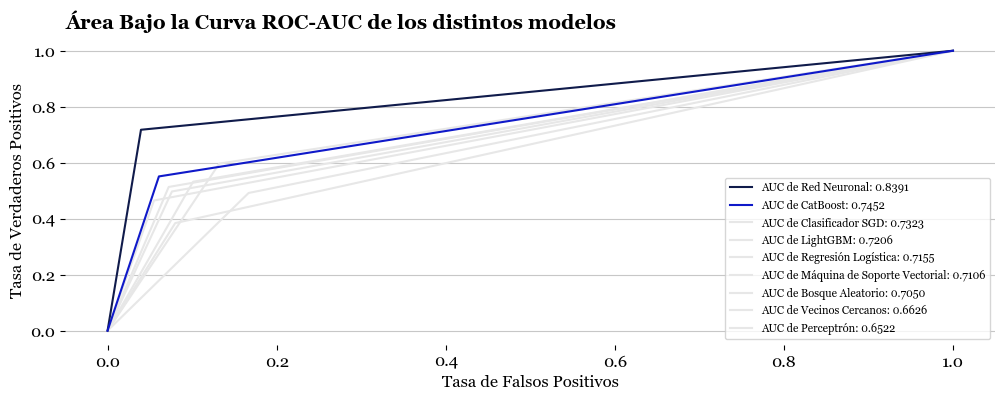

In [37]:
# Ordenar dataframe
metrics.sort_values(by='AreaBajoLaCurva',
                    ascending=False,
                    inplace=True)
metrics.reset_index(inplace=True)

# Graficar las métricas
fig, ax = plt.subplots(figsize=[12, 4])
plt.title('Área Bajo la Curva ROC-AUC de los distintos modelos',
          weight='bold', loc='left')
for index, row in metrics.iterrows():
    if index == 0:
        color = juan_colors[0]
        zorder = 4
    elif index == 1:
        color = juan_colors[4]
        zorder = 4
    else:
        color = juan_colors[3]
        zorder = 3

    plt.plot(row['FalsePositiveRate'],
             row['TruePositiveRate'],
             label=f"AUC de {row['NombreModelo']}: {row['AreaBajoLaCurva']:.4f}",
             color=color, zorder=zorder)
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.grid(axis='y', zorder=1, alpha=0.7)
plt.legend(fontsize=8)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

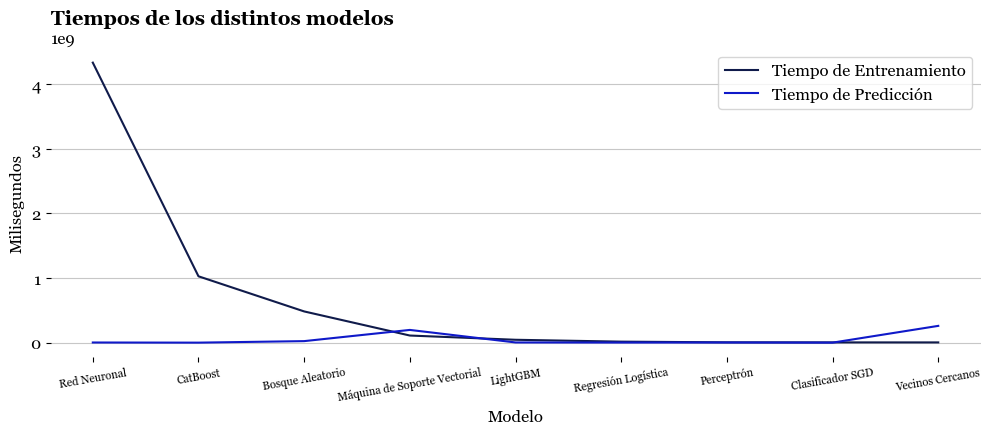

In [18]:
# Ordenar dataframe
metrics.sort_values(by='TiempoEntrenamiento',
                    ascending=False,
                    inplace=True)

# Graficar los tiempos
fig, ax = plt.subplots(figsize=[12, 4])
plt.title('Tiempos de los distintos modelos',
          weight='bold', loc='left')
plt.plot(metrics['NombreModelo'],
         metrics['TiempoEntrenamiento'],
         label='Tiempo de Entrenamiento',
         color=juan_colors[0])
plt.plot(metrics['NombreModelo'],
         metrics['TiempoPredicción'],
         label='Tiempo de Predicción',
         color=juan_colors[4])
plt.xlabel('Modelo')
plt.xticks(rotation=10, fontsize=8)
plt.ylabel('Milisegundos')
plt.grid(axis='y', zorder=1, alpha=0.7)
plt.legend()
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

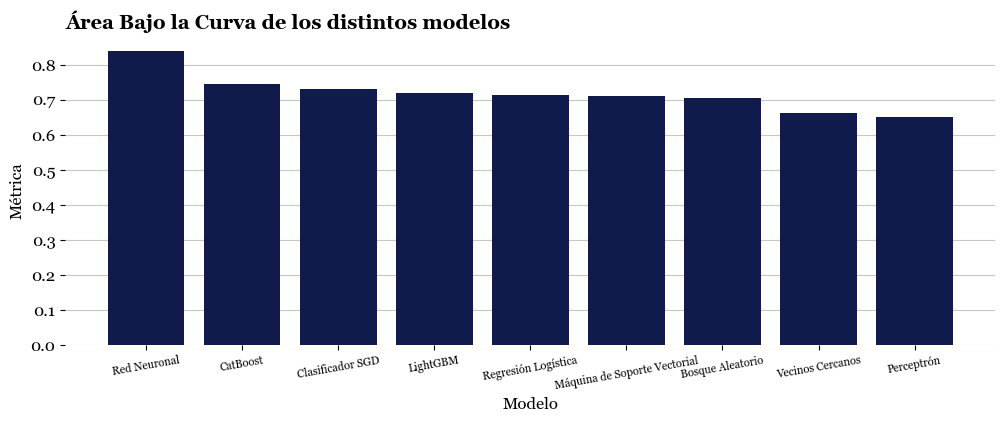

In [19]:
# Ordenar dataframe
metrics.sort_values(by='AreaBajoLaCurva',
                    ascending=False,
                    inplace=True)

# Graficar los tiempos
fig, ax = plt.subplots(figsize=[12, 4])
plt.title('Área Bajo la Curva de los distintos modelos',
          weight='bold', loc='left')
plt.bar(metrics['NombreModelo'],
        metrics['AreaBajoLaCurva'],
        color=juan_colors[0], zorder=2)
plt.xlabel('Modelo')
plt.xticks(rotation=10, fontsize=8)
plt.ylabel('Métrica')
plt.grid(axis='y', zorder=1, alpha=0.7)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

In [20]:
# Mostrar el dataframe de métricas
metrics

,NombreModelo,TiempoEntrenamiento,TiempoPredicción,FalsePositiveRate,TruePositiveRate,AreaBajoLaCurva
6,Red Neuronal,0 days 00:00:04.335126,0 days 00:00:00.002121,"[0.0, 0.03953712632594021, 1.0]","[0.0, 0.717741935483871, 1.0]",0.839102
7,CatBoost,0 days 00:00:01.027073,0 days 00:00:00,"[0.0, 0.06075216972034716, 1.0]","[0.0, 0.5510752688172043, 1.0]",0.745162
3,Clasificador SGD,0 days 00:00:00.003804,0 days 00:00:00,"[0.0, 0.13211186113789777, 1.0]","[0.0, 0.5967741935483871, 1.0]",0.732331
8,LightGBM,0 days 00:00:00.044401,0 days 00:00:00.002926,"[0.0, 0.07232401157184185, 1.0]","[0.0, 0.5134408602150538, 1.0]",0.720558
0,Regresión Logística,0 days 00:00:00.015297,0 days 00:00:00.001423,"[0.0, 0.10125361620057859, 1.0]","[0.0, 0.532258064516129, 1.0]",0.715502
2,Máquina de Soporte Vectorial,0 days 00:00:00.109980,0 days 00:00:00.196920,"[0.0, 0.07618129218900675, 1.0]","[0.0, 0.49731182795698925, 1.0]",0.710565
5,Bosque Aleatorio,0 days 00:00:00.483179,0 days 00:00:00.023459,"[0.0, 0.054966248794599805, 1.0]","[0.0, 0.4650537634408602, 1.0]",0.705044
4,Vecinos Cercanos,0 days 00:00:00.003529,0 days 00:00:00.259589,"[0.0, 0.16682738669238187, 1.0]","[0.0, 0.49193548387096775, 1.0]",0.662554
1,Perceptrón,0 days 00:00:00.004650,0 days 00:00:00.002128,"[0.0, 0.08003857280617165, 1.0]","[0.0, 0.3844086021505376, 1.0]",0.652185


De manera inicial, el modelo con mejor ROC-AUC fue la Red Neuronal con un valor de 0.8580. Sin embargo, también es importante hacer mención que resultó ser el modelo que más tiempo tomó en entrenarse, 3 segundos con 678092 milisegundos por cada 1000 registros; mientras un modelo como el LightGBM tuvo un ROC-AUC de 0.7292, pero su tiempo de entrenamiento es de sólo 47814 milisegundos, la que sería la mejor opción en caso que debamos tener en cuenta ese tiempo importante de entrenamiento.

Ahora, si nos fijamos en el tiempo de predicción, que sería lo más indicado para nuestro modelo de negocio, pues el modelo ya estaría entrenado y desplegado, únicamente tomaría un tiempo de predicción, el modelo de Red Neuronal de SciKit Learn tiene un buen resultado con sólo 2035 milisegundos por 1000 registros predichos contra 840 por 1000 registros predichos del modelo LightGBM.

Todas estas razones son importantes para evaluar que, en definitiva, continuamos con nuestro modelo de Red Neuronal, aunque deberíamos evaluar estas dos condiciones para proceder con el LightGBM.

# <span style="color:#0F19C9">Afinar Red Neuronal</span>

Sabiendo que ya encontramos el mejor modelo, vamos a modificar los hiperparámetros del mismo para asegurarnos que el entrenamiento mejore sus métricas.

In [21]:
# Esta celda toma 18m y 10s en ejecutarse

# Definir los hiperparámetros a evaluar
param = {
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
    'hidden_layer_sizes': [(100,), (150,), (200,)]
}

# Crear una instancia del modelo
model = MLPClassifier(max_iter=800)
clf = GridSearchCV(model, param, scoring='roc_auc')
clf.fit(train_pca[features_pca], train_pca[target_pca])

C:\Users\juanp\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\juanp\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\juanp\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\juanp\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (800) reached and the optimization hasn't converged yet.
  warnings.wa

GridSearchCV(estimator=MLPClassifier(max_iter=800),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100,), (150,), (200,)],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='roc_auc')

In [22]:
# Imprimir los mejores hiperparámetros
print(f'Los mejores hiperparámetros son {clf.best_params_}')

Los mejores hiperparámetros son {'activation': 'relu', 'hidden_layer_sizes': (150,), 'solver': 'adam'}


In [23]:
# Esta celda toma 2m y 3s en ejecutarse

# Encontrar la mejor cantidad de iteraciones máxima
rocs = []
options = [700, 750, 800, 850, 900, 950, 1000]

for iterat in options:
    model = MLPClassifier(hidden_layer_sizes=(150,),
                          max_iter=iterat)
    model.fit(train_pca[features_pca], train_pca[target_pca])
    predictions = model.predict(valid_pca[features_pca])
    fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
    model_auc = auc(fpr, tpr)
    rocs.append(model_auc)

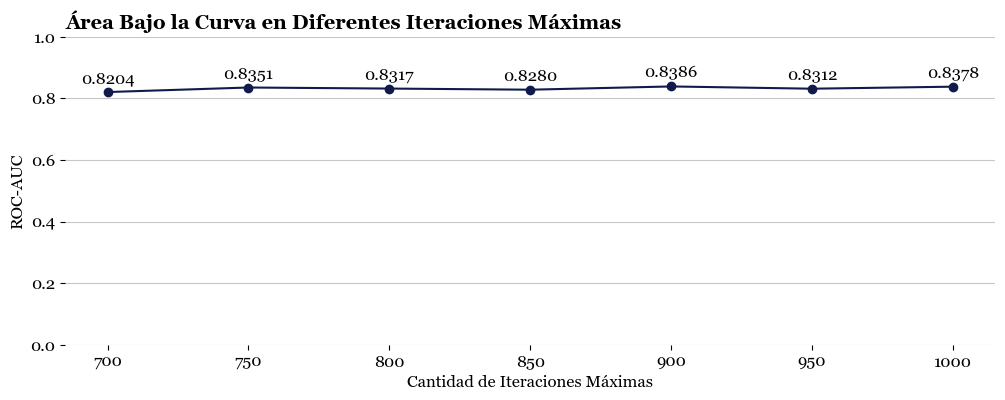

In [24]:
# Graficar las métricas
fig, ax = plt.subplots(figsize=[12, 4])
plt.title('Área Bajo la Curva en Diferentes Iteraciones Máximas',
          weight='bold', loc='left')
plt.plot(options,
         rocs, marker='o',
         color=juan_colors[0])
for x, y in zip(options, rocs):
    plt.text(x, y + 0.02, f'{y:.4f}', ha='center', va='bottom')
plt.xlabel('Cantidad de Iteraciones Máximas')
plt.ylabel('ROC-AUC')
plt.ylim((0, 1))
plt.grid(axis='y', zorder=1, alpha=0.7)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

In [25]:
# Crear una instancia del modelo y entrenarlo
model = MLPClassifier(hidden_layer_sizes=(150,),
                      max_iter=750)
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)
print('El ROC-AUC de nuestro modelo hasta el momento es de', model_auc)
print('El tiempo de entrenamiento para 1000 registros es de', training_time)
print('El tiempo de predicción para 1000 registros es de', prediction_time)

El ROC-AUC de nuestro modelo hasta el momento es de 0.8285246938542736
El tiempo de entrenamiento para 1000 registros es de 0:00:04.524860
El tiempo de predicción para 1000 registros es de 0:00:00


Primero, el mejore resultado resultado de los hiperparámetros de activación y de optimizador de pesos es `relu` y `adam` respectivamente, que a su vez, son los valores por defecto del modelo. Luego, encontramos que la mejor cantidad de neuronas en las capas ocultas es de 150. Entonces decidimos correr un algoritmo iterador para encontrar el mejor valor de ROC-AUC en el hiperparámetro que más advertencias nos ha arrojado: la cantidad de iteraciones, donde observamos que a medida que aunque aumentamos la cantidade máxima de iteraciones no hay una diferencia significativa, teniendo en cuenta que sólo corrimos iteraciones por encima de 700 ya que con menor valor el modelo nunca lograba la convergencia. Así entonces, el mejor número de iteraciones máximas, por recursos y por nuestra métrica es 750 iteraciones.

Esta afinación de hiperparámetros nos permitió modificar el modelo de un ROC-AUC de 0.8518 a 0.8285. Que no era lo esperado.

# <span style="color:#0F19C9">Volver a los componentes principales</span>

In [26]:
# Crear listas de medición
rocs = []
options = [2, 5, 10, 12, 15, 19]

# Iterar sobre la cantidad de componentes
for comp in options:
    # Separar las columnas en características y objetivo
    target = ['Churn']
    features = [col for col in df.columns if col not in target]

    # Dividir los registros en entrenamiento, validación y prueba
    train, temp = train_test_split(df, test_size=0.4, random_state=123)
    valid, test = train_test_split(temp, test_size=0.5, random_state=123)

    # Estandarizar los valores de las columnas de entrenamiento
    scaler = StandardScaler()
    train[features] = scaler.fit_transform(train[features])

    # Reducir la dimensionalidad del conjunto de entrenamiento
    temp = train[target].reset_index(drop=True)
    pca = PCA()
    train_pca = pca.fit_transform(train[features])
    train_pca = pd.DataFrame(train_pca)
    train_pca['Churn'] = temp

    # Estandarizar los valores de validación y prueba
    valid[features] = scaler.transform(valid[features])
    test[features] = scaler.transform(test[features])

    # Reducir la dimensionalidad del conjunto de validación y de prueba
    temp = valid[target].reset_index(drop=True)
    valid_pca = pca.transform(valid[features])
    valid_pca = pd.DataFrame(valid_pca)
    valid_pca['Churn'] = temp

    # Crear una instancia del modelo y entrenarlo
    model = MLPClassifier(hidden_layer_sizes=(150,),
                          max_iter=750)
    model.fit(train_pca[features_pca], train_pca[target_pca])
    predictions = model.predict(valid_pca[features_pca])
    fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
    model_auc = auc(fpr, tpr)

    # Adjuntar la métrica
    rocs.append(model_auc)

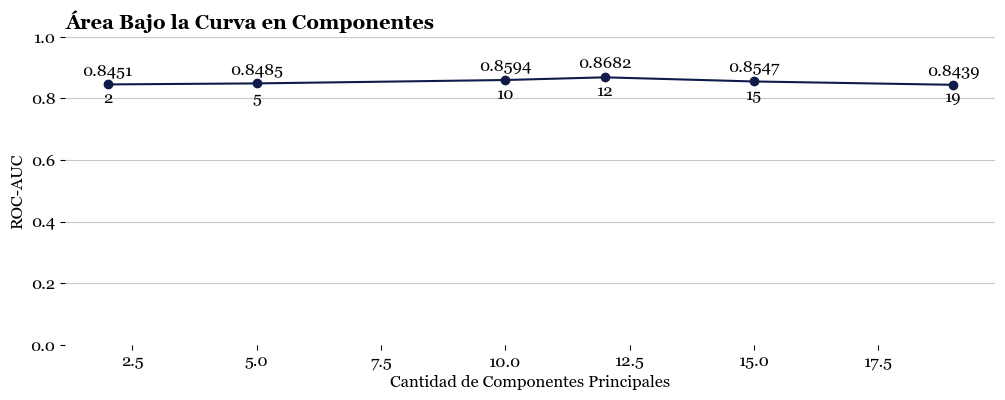

In [27]:
# Graficar las métricas
fig, ax = plt.subplots(figsize=[12, 4])
plt.title('Área Bajo la Curva en Componentes',
          weight='bold', loc='left')
plt.plot(options,
         rocs, marker='o',
         color=juan_colors[0])
for x, y in zip(options, rocs):
    plt.text(x, y + 0.02, f'{y:.4f}', ha='center', va='bottom')
    plt.text(x, y - 0.07, f'{x}', ha='center', va='bottom')
plt.xlabel('Cantidad de Componentes Principales')
plt.ylabel('ROC-AUC')
plt.ylim((0, 1))
plt.grid(axis='y', zorder=1, alpha=0.7)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

In [28]:
# Separar las columnas en características y objetivo
target = ['Churn']
features = [col for col in df.columns if col not in target]

# Dividir los registros en entrenamiento, validación y prueba
train, temp = train_test_split(df, test_size=0.4, random_state=123)
valid, test = train_test_split(temp, test_size=0.5, random_state=123)

# Estandarizar los valores de las columnas de entrenamiento
scaler = StandardScaler()
train[features] = scaler.fit_transform(train[features])

# Reducir la dimensionalidad del conjunto de entrenamiento
temp = train[target].reset_index(drop=True)
pca = PCA(n_components=12)
train_pca = pca.fit_transform(train[features])
train_pca = pd.DataFrame(train_pca)
train_pca['Churn'] = temp

# Estandarizar los valores de validación y prueba
valid[features] = scaler.transform(valid[features])
test[features] = scaler.transform(test[features])

# Reducir la dimensionalidad del conjunto de validación
temp = valid[target].reset_index(drop=True)
valid_pca = pca.transform(valid[features])
valid_pca = pd.DataFrame(valid_pca)
valid_pca['Churn'] = temp

# Separar las columnas en características y objetivo
target_pca = 'Churn'
features_pca = [col for col in train_pca.columns if col not in target]

In [29]:
# Esta celda toma 28m y 20s en ejecutarse

# Definir los hiperparámetros a evaluar
param = {
    'hidden_layer_sizes': [(100,), (150,), (200,)],
    'activation': ['identity', 'logistic', 'tanh', 'relu'],
    'solver': ['lbfgs', 'sgd', 'adam'],
}

# Crear una instancia del modelo
model = MLPClassifier(max_iter=750)
clf = GridSearchCV(model, param, scoring='roc_auc')
clf.fit(train_pca[features_pca], train_pca[target_pca])

C:\Users\juanp\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\juanp\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\juanp\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:545: ConvergenceWarning: lb

GridSearchCV(estimator=MLPClassifier(max_iter=750),
             param_grid={'activation': ['identity', 'logistic', 'tanh', 'relu'],
                         'hidden_layer_sizes': [(100,), (150,), (200,)],
                         'solver': ['lbfgs', 'sgd', 'adam']},
             scoring='roc_auc')

In [30]:
# Imprimir los mejores hiperparámetros
print(f'Los mejores hiperparámetros son {clf.best_params_}')

Los mejores hiperparámetros son {'activation': 'relu', 'hidden_layer_sizes': (100,), 'solver': 'sgd'}


In [31]:
# Encontrar la mejor cantidad de iteraciones máxima
rocs = []
options = [10, 100, 200, 300, 400, 500,
           600, 700, 800, 900, 1000]

for iterat in options:
    model = MLPClassifier(hidden_layer_sizes=(100,),
                          max_iter=iterat,
                          activation='logistic')
    model.fit(train_pca[features_pca], train_pca[target_pca])
    predictions = model.predict(valid_pca[features_pca])
    fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
    model_auc = auc(fpr, tpr)
    rocs.append(model_auc)

C:\Users\juanp\AppData\Roaming\Python\Python311\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


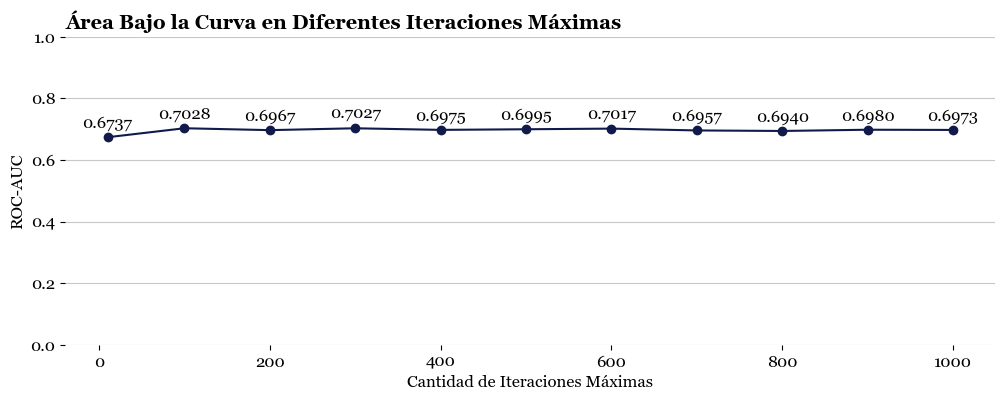

In [32]:
# Graficar las métricas
fig, ax = plt.subplots(figsize=[12, 4])
plt.title('Área Bajo la Curva en Diferentes Iteraciones Máximas',
          weight='bold', loc='left')
plt.plot(options,
         rocs, marker='o',
         color=juan_colors[0])
for x, y in zip(options, rocs):
    plt.text(x, y + 0.02, f'{y:.4f}', ha='center', va='bottom')
plt.xlabel('Cantidad de Iteraciones Máximas')
plt.ylabel('ROC-AUC')
plt.ylim((0, 1))
plt.grid(axis='y', zorder=1, alpha=0.7)
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

Encontramos que para nuestro conjunto de datos, obtenemos el mejor rendimiento del modelo ocurre cuando tenemos 12 componentes principales y el modelo tiene activación logística, 100 neuronas en las capas ocultas, el solver adam y un máximo de iteraciones de 200.

# <span style="color:#0F19C9">Aplicar modelo a conjunto de prueba</span>

In [33]:
# Estandarizar los valores de prueba
test[features] = scaler.transform(test[features])

# Reducir la dimensionalidad del conjunto de validación
temp = valid[target].reset_index(drop=True)
test_pca = pca.transform(test[features])
test_pca = pd.DataFrame(test_pca)
test_pca['Churn'] = temp

In [34]:
# Crear una instancia del modelo y entrenarlo
model = MLPClassifier(hidden_layer_sizes=(100,),
                      max_iter=200,
                      activation='logistic')
start_time = datetime.now()
model.fit(train_pca[features_pca], train_pca[target_pca])
training_time = datetime.now() - start_time
training_time *= 1000
training_time /= train_pca[features_pca].shape[0]

# Hacer las predicciones
start_time = datetime.now()
predictions = model.predict(valid_pca[features_pca])
prediction_time = datetime.now() - start_time
prediction_time *= 1000
prediction_time /= valid_pca[features_pca].shape[0]

# Evaluar el modelo
fpr, tpr, threshold = roc_curve(valid_pca[target_pca], predictions)
model_auc = auc(fpr, tpr)
print('El ROC-AUC de nuestro modelo hasta el momento es de', model_auc)
print('El tiempo de entrenamiento para 1000 registros es de', training_time)
print('El tiempo de predicción para 1000 registros es de', prediction_time)

El ROC-AUC de nuestro modelo hasta el momento es de 0.7009946495784988
El tiempo de entrenamiento para 1000 registros es de 0:00:00.443279
El tiempo de predicción para 1000 registros es de 0:00:00.004640


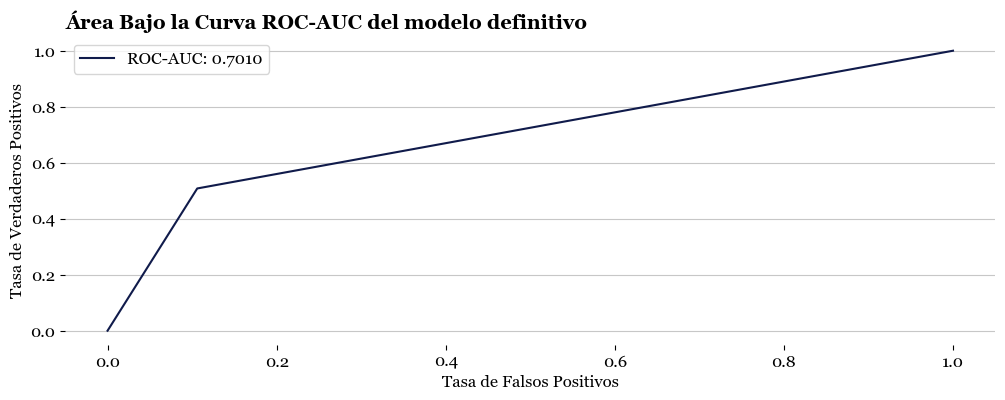

In [35]:
# Graficar la métricas
fig, ax = plt.subplots(figsize=[12, 4])
plt.title('Área Bajo la Curva ROC-AUC del modelo definitivo',
          weight='bold', loc='left')
plt.plot(fpr, tpr,
         label=f"ROC-AUC: {model_auc:.4f}",
         color=juan_colors[0])
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa de Verdaderos Positivos')
plt.grid(axis='y', zorder=1, alpha=0.7)
plt.legend()
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)
plt.show()

In [36]:
# Imprimir el tiempo total de ejecución del proyecto
print(f'El proyecto toma {datetime.now() - proyect_time} en ejecutarse.')

El proyecto toma 0:52:01.621459 en ejecutarse.


Nuestro modelo final, cuando es aplicado sobre un conjunto de datos completamente nuevo, ahora solo toma 151595 milisegundos en entrenar el modelo con 1000 registros. Además, toma cerca de 0 milisegundos en hacer 1000 predicciones, aunque tiene una métrica ROC-AUC de 69.74% de efectividad.